In [149]:
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor, load, save
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pickle
import ssl

In [150]:
ssl._create_default_https_context = ssl._create_unverified_context
device = "cpu"

In [151]:
IMG_DIR = "../data/nutrition5k_dataset_nosides/imagery/realsense_overhead/"

DATASET_DIR = "../data/nutrition5k_dataset_nosides/"
PROCESSED_DIR = os.path.join(DATASET_DIR, "processed")

INGREDIENTS_PATH = os.path.join(PROCESSED_DIR, "ingredients_metadata.csv")
DISHES_PATH = os.path.join(PROCESSED_DIR, "dishes_info.csv")

In [152]:
def find_empty_directories(directory):
    empty_dirs = []
    
    for dirpath, dirnames, files in os.walk(directory):
        if not dirnames and not files:
            empty_dirs.append(dirpath.split("/")[-1])
    
    return empty_dirs

empty_folder_names = find_empty_directories(IMG_DIR)
print(empty_folder_names)

['dish_1558109714', 'dish_1558109511', 'dish_1557862384']


In [153]:
df = pd.read_csv(DISHES_PATH)
print(len(df["dish_id"].index))
print(len(df[~df["dish_id"].isin(empty_folder_names)].index))


3493
3490


In [154]:
df = pd.read_csv(INGREDIENTS_PATH)
labels = df["ingredient_id"]

label_binarizer = MultiLabelBinarizer()
label_binarizer.fit([labels.to_list()])

num_of_classes = label_binarizer.classes_.shape[0]
print("number of classes:", num_of_classes)
# label_binarizer.transform([[2, 3]])[0]

number of classes: 247


In [155]:
with open('mlb.pkl', 'wb') as f:
    pickle.dump(label_binarizer, f)

In [156]:
class IngredientDataset(Dataset):
    def __init__(self, img_dir: str, ingredients_path: str, dish_info_path: str, transform=None, ignore_dish_ids=[]):
        self.img_dir = img_dir

        self.ing_df = pd.read_csv(ingredients_path)
        self.dish_info_df = pd.read_csv(dish_info_path)

        if len(ignore_dish_ids) > 0:
            self.ing_df = self.ing_df[~self.ing_df["dish_id"].isin(ignore_dish_ids)]
            self.dish_info_df = self.dish_info_df[~self.dish_info_df["dish_id"].isin(ignore_dish_ids)]

        self.transform = transform

        self.label_binarizer = MultiLabelBinarizer()
        self.label_binarizer.fit([self.ing_df["ingredient_id"].to_list()])

    def __len__(self) -> int:
        return len(self.dish_info_df)

    def __getitem__(self, index):
        dish = self.dish_info_df.iloc[index]
        dish_id = dish[0]
        # print(dish_id)

        ingredient_ids = self.ing_df[self.ing_df["dish_id"] == dish_id]["ingredient_id"].values
        label_encoded = self.label_binarizer.transform([ingredient_ids])[0]
        label_tensor = torch.LongTensor(label_encoded)
        # print(label_tensor)

        dish_weight = dish[2]
        # print(dish_weight)
        weight_in_g_tensor = torch.FloatTensor([dish_weight])

        img_path = os.path.join(self.img_dir, dish_id, "rgb.png")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = np.transpose(img, (2, 0, 1))
        # plt.imshow(img)
        # plt.show()

        img_tensor = torch.FloatTensor(img)
        img_tensor = self.transform(img_tensor) if self.transform is not None else img_tensor

        return img_tensor, label_tensor, weight_in_g_tensor

    def get_num_of_classes(self) -> int:
        return self.label_binarizer.classes_.shape[0]

In [157]:
# def get_multi_label_accuracy(y_pred: Tensor, y_target: Tensor, thresh = 0.5) -> float:
#     y_pred_binary = (y_pred > thresh).float()
#     correct = (y_pred_binary == y_target).sum().item()
#     return correct / len(y_target)

In [158]:
def get_multi_label_accuracy(y_pred: Tensor, y_target: Tensor, thresh = 0.5) -> float:
    # Apply threshold and convert predictions to binary format
    y_pred_binary = (y_pred > thresh).float()
    # print(y_pred_binary)
    print(np.count_nonzero(y_pred_binary, axis=1))
    # print(y_target)
    print(np.count_nonzero(y_target, axis=1))
    
    # Calculate the number of correct predictions
    correct = (y_pred_binary == y_target).sum().item()

    # Calculate and return the accuracy
    return correct / y_pred_binary.numel() 

y_pred = torch.FloatTensor([[0.8, 0.3, 0.9, 0.54]])
y_target = torch.LongTensor([[0, 0, 1, 1]])
get_multi_label_accuracy(y_pred, y_target, thresh = 0.5)

[3]
[2]


0.75

In [159]:
def get_multi_label_accuracy_positives(y_pred: Tensor, y_target: Tensor, thresh = 0.5) -> float:
    # Apply threshold and convert predictions to binary format
    y_pred_binary = (y_pred > thresh).float()
    # print(y_pred_binary)
    # print(y_target)

    # Create a mask of where the target tensor is 1
    mask = (y_target == 1)

    # Use the mask to select only the corresponding predictions 
    y_pred_binary_masked = y_pred_binary[mask]
    y_target_masked = y_target[mask]

    # Calculate the number of correct predictions
    correct = (y_pred_binary_masked == y_target_masked).sum().item()

    # Calculate and return the accuracy
    return correct / y_pred_binary_masked.numel()
    
y_pred = torch.FloatTensor([[0.8, 0.3, 0.9, 0.0]])
y_target = torch.LongTensor([[0, 0, 1, 1]])
get_multi_label_accuracy_positives(y_pred, y_target, thresh = 0.5)

0.5

In [160]:
def print_statistics(epoch: int, batch: int, num_batches: int, loss: float, acc: float):
    print(f"EPOCH {epoch + 1} | BATCH {batch + 1} of {num_batches} | LOSS {loss:.4f} | ACCURACY {acc:.4f}")

In [161]:
def average_chunkwise(list, size: int, num_epochs: int):
    return [sum(list[i * size: (i + 1) * size]) / size for i in range(num_epochs)]

In [162]:
dataset = IngredientDataset(img_dir=IMG_DIR, ingredients_path=INGREDIENTS_PATH, dish_info_path=DISHES_PATH, ignore_dish_ids=empty_folder_names)

training_dataset, validation_dataset = random_split(dataset, [0.7, 0.3])

training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [163]:
num_classes = dataset.get_num_of_classes()
model = torchvision.models.mobilenet_v3_small(pretrained=True)

num_ftrs = model.classifier[3].in_features

model.classifier[3] = nn.Sequential(
    nn.Linear(num_ftrs, num_classes),
    nn.Softmax()
)

/Users/maxburzer/Desktop/SnackTrack-Backend/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maxburzer/Desktop/SnackTrack-Backend/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [164]:
loss_function = nn.MultiLabelMarginLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# collect stats
train_loss = []
train_acc = []
val_acc = []

In [167]:
num_epochs = 1

for epoch in range(num_epochs):
    
    model.train()
    torch.enable_grad()
    print("TRAINING...")

    for index, (X_train, y_train, y_w_train) in enumerate(training_dataloader):
        # move to GPU
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # forward
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        acc = get_multi_label_accuracy_positives(y_pred, y_train)

        # collect stats
        train_loss.append(loss.item())
        train_acc.append(acc)
        print_statistics(epoch, index, len(training_dataloader), loss.item(), acc)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    torch.no_grad()
    print("TESTING...")

    for index, (X_val, y_val, y_w_train) in enumerate(validation_dataloader):
        # move to GPU
        X_val = X_val.to(device)
        y_val = y_val.to(device)

        # forward
        y_pred = model(X_val)
        acc = get_multi_label_accuracy_positives(y_pred, y_val)

        # collect stats
        val_acc.append(acc)
        print_statistics(epoch, index, len(validation_dataloader), 0, acc)

TRAINING...


/var/folders/18/mk89nqqd4t1738cgptywpmw00000gn/T/ipykernel_25417/3341799250.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dish_id = dish[0]
/var/folders/18/mk89nqqd4t1738cgptywpmw00000gn/T/ipykernel_25417/3341799250.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dish_weight = dish[2]


EPOCH 1 | BATCH 1 of 77 | LOSS 11.1279 | ACCURACY 0.0000
EPOCH 1 | BATCH 2 of 77 | LOSS 6.3544 | ACCURACY 0.0000
EPOCH 1 | BATCH 3 of 77 | LOSS 6.6643 | ACCURACY 0.0000
EPOCH 1 | BATCH 4 of 77 | LOSS 4.9285 | ACCURACY 0.0000
EPOCH 1 | BATCH 5 of 77 | LOSS 6.9123 | ACCURACY 0.0045
EPOCH 1 | BATCH 6 of 77 | LOSS 8.2762 | ACCURACY 0.0000
EPOCH 1 | BATCH 7 of 77 | LOSS 7.0983 | ACCURACY 0.0000
EPOCH 1 | BATCH 8 of 77 | LOSS 8.7721 | ACCURACY 0.0000
EPOCH 1 | BATCH 9 of 77 | LOSS 7.1293 | ACCURACY 0.0000
EPOCH 1 | BATCH 10 of 77 | LOSS 6.6334 | ACCURACY 0.0000
EPOCH 1 | BATCH 11 of 77 | LOSS 5.4865 | ACCURACY 0.0000
EPOCH 1 | BATCH 12 of 77 | LOSS 7.1293 | ACCURACY 0.0000
EPOCH 1 | BATCH 13 of 77 | LOSS 5.7964 | ACCURACY 0.0000
EPOCH 1 | BATCH 14 of 77 | LOSS 5.8894 | ACCURACY 0.0000
EPOCH 1 | BATCH 15 of 77 | LOSS 5.8584 | ACCURACY 0.0000
EPOCH 1 | BATCH 16 of 77 | LOSS 5.7034 | ACCURACY 0.0000
EPOCH 1 | BATCH 17 of 77 | LOSS 8.3692 | ACCURACY 0.0000
EPOCH 1 | BATCH 18 of 77 | LOSS 7.4083 

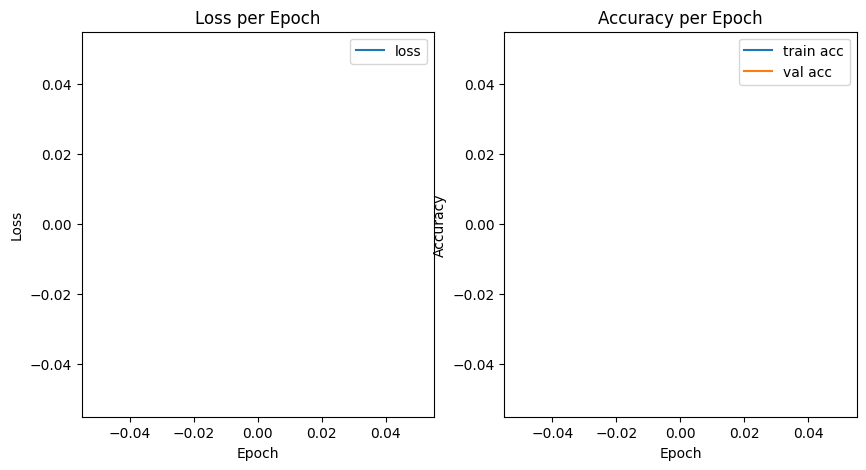

In [201]:
plt.figure(figsize=(10, 5))

trained_epochs = len(train_loss) // len(training_dataloader)
avg_train_loss = average_chunkwise(train_loss, len(training_dataloader), trained_epochs)
avg_train_acc = average_chunkwise(train_acc, len(training_dataloader), trained_epochs)
avg_val_acc = average_chunkwise(val_acc, len(validation_dataloader), trained_epochs)

plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label="loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label="train acc")
plt.plot(avg_val_acc, label="val acc")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [205]:
model = model.cpu()
with open('model_state.pt', 'wb') as f: 
        save(model.state_dict(), f)
model = model.to(device)

In [98]:
with open('model_state.pt', 'rb') as f: 
        model.load_state_dict(load(f))  

In [353]:
from typing import List, Tuple


class Predictor:
    def __init__(self, num_classes=247):
        self.model = torchvision.models.mobilenet_v3_small()

        num_ftrs = self.model.classifier[3].in_features
        self.model.classifier[3] = torch.nn.Linear(num_ftrs, num_classes)

        with open("model_state.pt", "rb") as f:
            self.model.load_state_dict(load(f))

        with open("mlb.pkl", "rb") as f:
            self.mlb: MultiLabelBinarizer = pickle.load(f)

        self.df = pd.read_csv("ingredients_metadata.csv")

    def predict(self, img=None, topk=5) -> List[Tuple[str, float]]:
        # output = self.model(img)
        tensor = dataset[0][0]
        # print(tensor.shape)

        output = self.model(tensor[None, :, :, :])
        # print(output)

        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        # print(probabilities)

        top_probs, indices = torch.topk(probabilities, topk)
        # print(indices)
        # print(top_probs.tolist())

        # Create a zeros tensor of the same shape
        mask = torch.zeros_like(probabilities)
        # print(mask)

        # Set the top 1 position to 1
        mask[indices] = 1
        # print(mask.view(1, -1).shape[1])

        ingredient_ids = self.mlb.inverse_transform(mask.view(1, -1))[0]
        # print(ingredient_ids)

        ingredient_names = [self.df.loc[self.df['id'] == id, 'ingr'].values[0] for id in list(ingredient_ids)] 
        # print(ingredient_names)

        return list(zip(ingredient_names, top_probs.tolist()))

In [354]:
predictor = Predictor()
predictor.predict()

/var/folders/18/mk89nqqd4t1738cgptywpmw00000gn/T/ipykernel_11965/1207756736.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dish_id = dish[0]
/var/folders/18/mk89nqqd4t1738cgptywpmw00000gn/T/ipykernel_11965/1207756736.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dish_weight = dish[2]


[('olives', 0.03650191053748131),
 ('bell peppers', 0.0290975384414196),
 ('vinegar', 0.02264178730547428),
 ('pepper', 0.020832356065511703),
 ('cherry tomatoes', 0.02059026062488556)]